In [1]:
import numpy as np
import os
import PIL.Image
from matplotlib import pyplot as plt
import scipy.spatial.distance

In [2]:
def read_faces(dir_path):
    faces = []
    labels = []
    for filename in os.listdir(dir_path):
        with PIL.Image.open(dir_path + filename) as im:
            im = im.resize((50, 50), PIL.Image.BILINEAR)
            faces.append([np.array(im).reshape(1, -1)])
            labels.append(filename.split('.', 1)[0])
    faces = np.concatenate(faces, axis=0)
    faces = faces.reshape(faces.shape[0], faces.shape[2])
    faces = faces.astype('int64')
    return faces, labels

In [3]:
DATASET_DIR = './Yale_Face_Database/'
TRAIN_DIR = DATASET_DIR + 'Training/'
TEST_DIR = DATASET_DIR + 'Testing/'
if not os.path.exists('./output'):
    os.mkdir('./output')

train_faces, train_labels = read_faces(TRAIN_DIR)
test_faces, test_labels = read_faces(TEST_DIR)

In [4]:
def get_covariance(datas):
    n = datas.shape[0]
    S = datas - np.sum(datas, axis=0) / n
    S = np.matmul(S, S.T) / n
    return S

In [5]:
def get_sorted_eigen(A, k):
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    sorted_idx = np.flip(np.argsort(eigenvalues))
    sorted_eigenvalues = []
    sorted_eigenvectors = []
    for i in range(k):
        vector = eigenvectors[:, sorted_idx[i]]
        sorted_eigenvectors.append(vector[:, None])
        sorted_eigenvalues.append(eigenvalues[sorted_idx[i]])
    sorted_eigenvalues = np.array(sorted_eigenvalues)
    sorted_eigenvectors = np.concatenate(sorted_eigenvectors, axis=1)

    return sorted_eigenvalues, sorted_eigenvectors

In [6]:
def show_faces(faces, filename=None, col=5):
    #f = faces.reshape(-1,231,195)
    f = faces.reshape(-1, 50, 50)
    n = f.shape[0]
    all_faces = []
    for i in range(int(n / col)):
        all_faces.append([np.concatenate(f[col * i:col * (i + 1)], axis=1)])

    all_faces = np.concatenate(all_faces[:], axis=1)
    all_faces = all_faces.reshape(all_faces.shape[1], all_faces.shape[2])

    plt.figure(figsize=(1.5 * col, 1.5 * n / col))
    plt.title(filename)
    plt.imshow(all_faces, cmap='gray')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15)

    if (filename):
        plt.savefig('./output/' + filename)
    else:
        plt.show()

In [7]:
def PCA(datas,k):
    S = get_covariance(datas)
    e_vals, e_vecs = get_sorted_eigen(S, k)
    mean_datas = datas - np.sum(datas, axis=0) / datas.shape[0]
    W = np.matmul(mean_datas.T, e_vecs)
    W /= np.sqrt(e_vals)
    pca_space = np.matmul(datas, W)
    return pca_space, W

In [9]:
pca_space, W = PCA(train_faces,25)
print(W.dtype)

float64


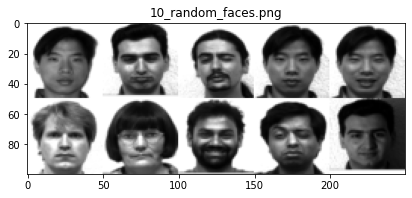

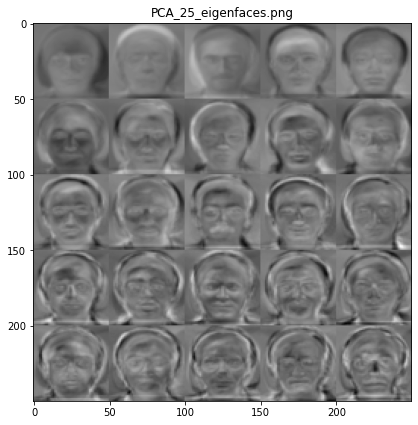

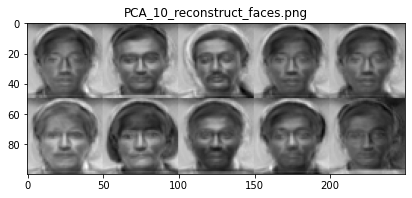

In [10]:
random_faces = np.vstack([
    train_faces[r]
    for r in np.random.randint(0, train_faces.shape[0], size=10)
])
reconstruct_faces = np.matmul(np.matmul(random_faces, W), W.T)

show_faces(random_faces, '10_random_faces.png')
show_faces(W.T, 'PCA_25_eigenfaces.png')
show_faces(reconstruct_faces, 'PCA_10_reconstruct_faces.png')

In [11]:
def euclidean(U, V):
    return np.matmul(U**2, np.ones(
        (U.shape[1], V.shape[0]))) - 2 * np.matmul(U, V.T) + np.matmul(
            np.ones((U.shape[0], V.shape[1])), (V.T)**2)

In [79]:
U = np.array([[1,2,3]])
V = np.array([[4,5,6]])
print(euclidean(U, V))
print((U-V) @ (U-V).T)

[[27.]]
[[27]]


In [12]:
def Predict(train_space, test_space, train_labels, k):    
    train_labels = np.asarray(train_labels)
    dist = euclidean(train_space, test_space)
    closet = np.argsort(dist, axis=0)
    #chose first k nearest neighbor
    p = []
    for i in range(closet.shape[1]):
        for j in range(k):
            p.append(train_labels[closet[j, i]])
    p = np.asarray(p)
    p = p.reshape(closet.shape[1], k)
    #who is most popular in the k nearest neighbor
    count = []
    for i in range(len(train_labels)):
        count.append(np.count_nonzero(p == train_labels[i], axis=1))
    count = np.vstack(count)
    #assign the testdatas into different type depend on "count"
    res = np.argmax(count, axis=0)
    predict = []
    for i in range(len(res)):
        predict.append(train_labels[res[i]])
    predict = np.asarray(predict)
    acc = 0
    for i in range(len(test_labels)):
        if predict[i] == test_labels[i]:
            acc += 1
    print('LDA Accuracy : {}%'.format(acc/len(test_labels)*100.00))

In [13]:
train_space, W_train = PCA(train_faces,25)
test_space = np.matmul(test_faces, W_train)
Predict(train_space, test_space, train_labels, 5)

LDA Accuracy : 90.0%


LDA

In [14]:
target = ['subject01','subject02','subject03','subject04',
        'subject05','subject06','subject07','subject08',
        'subject09','subject10','subject11','subject12',
        'subject13','subject14','subject15']

In [15]:
def get_Sb_Sw(train_faces, train_labels):
    train_labels = np.asarray(train_labels)
    n = train_faces.shape[0]
    M = np.sum(train_faces, axis = 0) / n
    M = M.reshape(1,-1)
    Sb = np.zeros([2500,2500])
    for i in range(len(target)):
        Mj = np.sum(train_faces[train_labels == target[i]], axis = 0) / 9
        Sb += 9 * (Mj.reshape(1,-1)-M).T @ (Mj.reshape(1,-1)-M)
    Sw = np.zeros([2500,2500])
    for i in range(len(target)):
        data = train_faces[train_labels == target[i]]
        Sw += (data-Mj[i].reshape(1,-1)).T @ (data-Mj[i].reshape(1,-1)) / 9

    return Sb, Sw, M

In [16]:
Sb, Sw, M = get_Sb_Sw(train_faces, train_labels)

In [17]:
Sw_inv = np.linalg.pinv(Sw)
obj_matrix = np.matmul(Sw_inv, Sb)
eigenvalue, eigenvector = get_sorted_eigen(obj_matrix, 25)

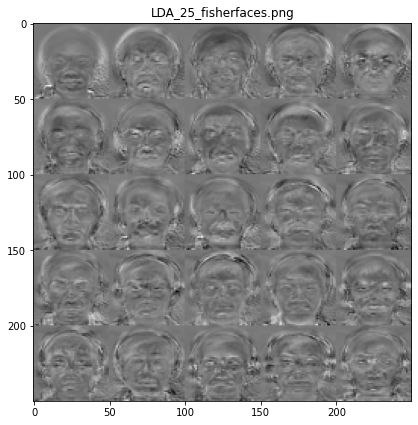

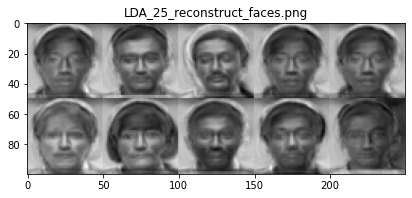

In [19]:
show_faces(eigenvector.T, 'LDA_25_fisherfaces.png')
reconstruct_faces = np.matmul(np.matmul(random_faces, W), W.T)
show_faces(reconstruct_faces, 'LDA_25_reconstruct_faces.png')

In [133]:
train_space = train_faces @ eigenvector
test_space = test_faces @ eigenvector
Predict(train_space, test_space, train_labels, 5)

LDA Accuracy : 93.33333333333333%


In [11]:
def get_KC(datas):
    n = datas.shape[0]
    N1 = np.ones((n, n)) / n
    S = (datas - np.matmul(N1, datas) - np.matmul(datas, N1) +
            np.matmul(np.matmul(N1, datas), N1))
    return S / 135.

In [12]:
def rbf(u, v, g=10**-10):
    return np.exp(-1 * g * euclidean(u, v))

def linear(u, v):
    return np.matmul(u, v.T)

def polynomial(u, v, g=0.7, coef0=10, d=5):
    return ((g * np.matmul(u, v.T)) + coef0)**d

In [111]:
def kernelLDA(X, label, kernel_type):
    label = np.asarray(label)
    c = np.unique(label)
    g=1e-7
    kernel = -1 * g * scipy.spatial.distance.cdist(X.T, X.T, 'sqeuclidean')
    kernel = np.exp(kernel)
    
    n = kernel.shape[0]
    mu = np.mean(kernel, axis=0)
    N = np.zeros((n, n), dtype=np.float64)
    M = np.zeros((n, n), dtype=np.float64)
    
    # compute M
    for i in c:
        K_i = kernel[np.where(label == i)[0], :]
        l = K_i.shape[0]
        mu_i = np.mean(K_i, axis=0)
        M +=  ((mu_i - mu).T @ (mu_i - mu))
    # compute N
    for i in c:
        K_i = kernel[np.where(label == i)[0], :]
        l = K_i.shape[0]
        N += K_i.T @ (np.eye(l) - (np.ones((l, l), dtype=np.float64) / l)) @ K_i

    return M, N

In [ ]:
def kernelLDA2(train_faces, train_labels):
    train_labels = np.asarray(train_labels)
    n = train_faces.shape[0]
    M = np.sum(train_faces, axis = 0) / n
    M = M.reshape(1,-1)
    Sb = np.zeros([2500,2500])
    for i in range(len(target)):
        Mj = np.sum(train_faces[train_labels == target[i]], axis = 0) / 9
        Sb += 9 * rbf((Mj.reshape(1,-1)-M).T, (Mj.reshape(1,-1)-M).T)
    Sw = np.zeros([2500,2500])
    for i in range(len(target)):
        data = train_faces[train_labels == target[i]]
        Sw += rbf((data-Mj[i].reshape(1,-1)).T, (data-Mj[i].reshape(1,-1)).T)

    return Sb, Sw, M

In [123]:
Sb_kernel, Sw_kernel = kernelLDA(train_faces, train_labels, 3)

In [124]:
Sb_kernel, Sw_kernel = kernelLDA(train_faces, train_labels, 3)
Sw_inv = np.linalg.pinv(Sw_kernel)
obj_matrix = np.matmul(Sw_inv, Sb_kernel)
eigenvalue, eigenvector = get_sorted_eigen(obj_matrix, 25)

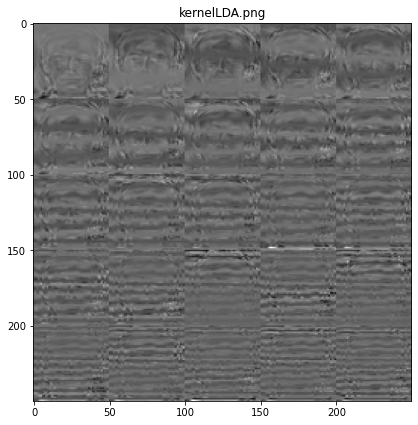

In [126]:
show_faces(eigenvector.T, "kernelLDA.png")

In [125]:
train_space = train_faces @ eigenvector
test_space = test_faces @ eigenvector
Predict(train_space, test_space, train_labels, 5)

LDA Accuracy : 83.33333333333334%


In [181]:
print(Sb_kernel.dtype)

float64


In [25]:
def kernel_PCA(datas, k):
    S = get_KC(datas)
    e_vals, e_vecs = get_sorted_eigen(S, k)
    W = e_vecs
    W /= np.sqrt(e_vals)
    return W

In [26]:
K_train = rbf(train_faces, train_faces)
K_test_train = rbf(test_faces, train_faces)
W = kernel_PCA(K_train, 25)
N1 = np.ones(K_train.shape) / K_train.shape[0]
NM1 = np.ones(K_test_train.shape) / K_train.shape[0]
train_space = np.matmul((K_train - np.matmul(N1, K_train)), W)
test_space = np.matmul((K_test_train - np.matmul(NM1, K_train)), W)

In [27]:
Predict(train_space, test_space, train_labels, 5)

LDA Accuracy : 90.0%


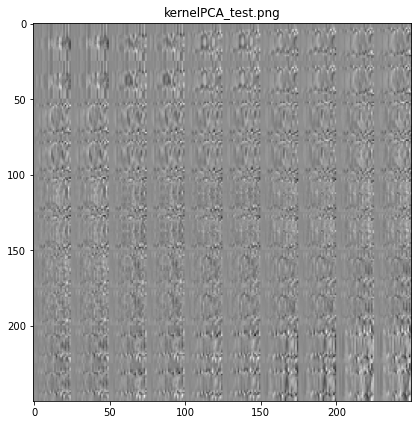

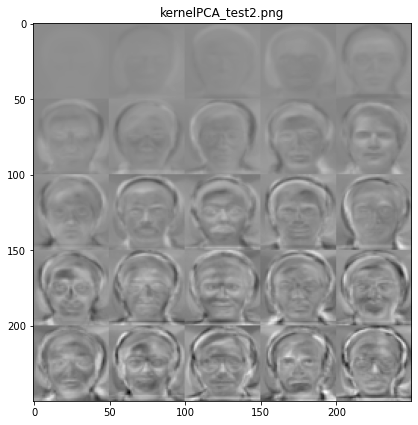

In [18]:
# show_faces(W_T, "kernelPCA_test.png")
# show_faces(W_T.T, "kernelPCA_test2.png")